# Objective

Look at flow cell "dirtiness" (i.e., how badly the background is contaminated by those small bright specks that build up) over time.

Include images with aberrations.

# Contents

This notebook calculates and shows image dirtiness over time.

For each image, the "dirtiness" is the sum of the binarized image with two bandpass filters to remove the "ghosts" divided by the image's total valid area.

Below the dirtiness vs. time plots, I've kept the examples of high dirtiness images (the outliers which were omitted from the plots) and normal dirtiness images.

Plot info:
- images with aberrations are included
- the y axis shows timestamp rather than run count
- historical event timepoints are shown
- average dirtiness over time is plotted
- one version has the datapoints connected; another has the datapoints as individual markers so it's easier to see when the different runs happened

Below these plots are the images identified as having aberrations and example images not identified as having aberrations.

# Conclusions

These were some of our questions:
- Is there a predictable upward dirtiness trend? I.e., does a certain number of runs increase dirtiness by a certain amount?
- Does the Contrad slow down the increase in dirtiness?

There did seem to be a somewhat steady upward trend in dirtiness from the beginning of this time period up until the CCI went out of focus, at which point the trend turned around. I'm really not sure what to make of the trend after that turnaround. Since there aren't too many time points after the switch to Contrad, it's hard to see what effect that switch had.

**New 8/7/22:** The inclusion of the images with aberrations in the plots does not seem to have affected the trends.

In [1]:
from skimage.io import imread, imsave
from skimage.util import img_as_float
from skimage.filters import difference_of_gaussians, threshold_otsu
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math, os, skimage, warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# for preparing the image before getting dirtiness
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

In [10]:
def get_dirtiness(img, save_processed_image):
    filtered1_image = difference_of_gaussians(img, sig_min, sig_max1)
    filtered2_image = difference_of_gaussians(filtered1_image, sig_min, sig_max2)
    filtered2_image[filtered2_image < 0.] = 0.
    filtered2_binary = filtered2_image > binarization_threshold     

    if save_processed_image:
        imsave(image_processed_path, filtered2_binary)

    dirtiness = np.sum(filtered2_binary)/filtered2_binary.size

    if dirtiness > high_dirtiness_thresh:

        # Select bright features
        feature_mask = img > bright_thresh
        labeled = skimage.measure.label(feature_mask)

        # Exclude small regions
        for props in skimage.measure.regionprops(labeled):
            if props.area < labeled.size * size_thresh:
                feature_mask[labeled == props.label] = 0

        # Grow
        grow_px = img.shape[0] * grow_factor
        for i in range(grow_cycles):
            feature_mask = skimage.segmentation.expand_labels(feature_mask,
                                                              grow_px)

        # Fill in hollow regions
        labeled = skimage.measure.label(~feature_mask)
        propses = skimage.measure.regionprops(labeled)
        areas = [(props.area, props.label) for props in propses]
        areas.sort()
        areas.pop()
        for area, label in areas:
            feature_mask[labeled == label] = 1

        # Also mask out undefined areas due to image alignment
        feature_mask[np.isnan(img)] = 1

        # Get binarized image with dirt
        filtered1_image = difference_of_gaussians(img, sig_min, sig_max1)
        filtered2_image = difference_of_gaussians(filtered1_image, sig_min, sig_max2)
        filtered2_image[filtered2_image < 0.] = 0.
        filtered2_binary = filtered2_image > binarization_threshold

        # Apply mask to identify dirty area in valid region
        valid_region = np.logical_not(feature_mask)
        dirty_area_in_valid_region = np.logical_and(filtered2_binary, valid_region)
        dirtiness = np.sum(dirty_area_in_valid_region)/np.sum(valid_region)
        
    return dirtiness

In [11]:
# for plotting results
def get_ts(xs):
    ts = []
    for name in xs:
        tokens = name.split('-')
        year = int(tokens[1][:4])
        month = int(tokens[1][4:6])
        day = int(tokens[1][6:8])
        hours = int(tokens[2][:2])
        minutes = int(tokens[2][2:4])
        seconds = int(tokens[2][4:])
        dtime = datetime(year, month, day, hours, minutes, seconds)
        ts.append(dtime)
    return ts

In [12]:
cropx, cropy = 1448, 1448
sig_min = 1
sig_max1 = 12
sig_max2 = 3

base_dir = '2022-04-27_GB20106_backgrounds_processed'
cols = ['image_name',
        'run_no',
        'lane_no',
        'binarization_threshold',
        'sum_bin_filtered2']

# params for deciding whether image has aberration
high_dirtiness_thresh = 0.004

# params for producing mask
grow_factor = 0.0375
bright_thresh = 14000
size_thresh = 3e-3 # was 3e-4
grow_cycles = 1

# params for getting image with dirt
binarization_threshold = 0.05

In [13]:
run_dirs = sorted(os.listdir(base_dir))
if '.DS_Store' in run_dirs:
    run_dirs.remove('.DS_Store')

In [15]:
binarization_threshold = 0.05
dirtinesses = {i: [] for i in range(8)}

for i, run_dir in enumerate(run_dirs):
    print(run_dir, '\t%d/%d' % (i, len(run_dirs)))
    data_dir = '%s/%s' % (base_dir, run_dir)
    image_names = sorted(os.listdir(data_dir))
    for image_name in image_names:
        if image_name[-6]!='-':
            continue
        lane_no = int(image_name.rsplit(".", 1)[0].rsplit("-", 1)[-1])

        path = '%s/%s' % (data_dir, image_name)
        image_processed_path = '%s/%s_processed.tif' % (data_dir, image_name[:-4])

        image = imread(path)

        image_cropped = crop_center(image,cropx,cropy)
        
        save_processed_image = True
        
        dirtiness = get_dirtiness(image_cropped, save_processed_image)
        
        dirtinesses[lane_no].append((image_name, dirtiness))
        print('\t%s\tdirtiness = %f\tthresh = %f' % (image_name, dirtiness, binarization_threshold))


20220106-104444 	0/83
	background-20220106-104444-0.tif	dirtiness = 0.000175	thresh = 0.050000
	background-20220106-104444-1.tif	dirtiness = 0.000372	thresh = 0.050000
	background-20220106-104444-2.tif	dirtiness = 0.000321	thresh = 0.050000
	background-20220106-104444-3.tif	dirtiness = 0.000872	thresh = 0.050000
	background-20220106-104444-4.tif	dirtiness = 0.000240	thresh = 0.050000
	background-20220106-104444-5.tif	dirtiness = 0.000721	thresh = 0.050000
	background-20220106-104444-6.tif	dirtiness = 0.000244	thresh = 0.050000
	background-20220106-104444-7.tif	dirtiness = 0.000227	thresh = 0.050000
20220107-111707 	1/83
	background-20220107-111707-0.tif	dirtiness = 0.000182	thresh = 0.050000
	background-20220107-111707-1.tif	dirtiness = 0.000430	thresh = 0.050000
	background-20220107-111707-2.tif	dirtiness = 0.000233	thresh = 0.050000
	background-20220107-111707-3.tif	dirtiness = 0.000879	thresh = 0.050000
	background-20220107-111707-4.tif	dirtiness = 0.000295	thresh = 0.050000
	backgr

	background-20220124-122801-4.tif	dirtiness = 0.000607	thresh = 0.050000
	background-20220124-122801-5.tif	dirtiness = 0.001135	thresh = 0.050000
	background-20220124-122801-6.tif	dirtiness = 0.001049	thresh = 0.050000
	background-20220124-122801-7.tif	dirtiness = 0.000666	thresh = 0.050000
20220125-103433 	14/83
	background-20220125-103433-0.tif	dirtiness = 0.000420	thresh = 0.050000
	background-20220125-103433-1.tif	dirtiness = 0.001197	thresh = 0.050000
	background-20220125-103433-2.tif	dirtiness = 0.000333	thresh = 0.050000
	background-20220125-103433-3.tif	dirtiness = 0.000896	thresh = 0.050000
	background-20220125-103433-4.tif	dirtiness = 0.000296	thresh = 0.050000
	background-20220125-103433-5.tif	dirtiness = 0.001215	thresh = 0.050000
	background-20220125-103433-6.tif	dirtiness = 0.001139	thresh = 0.050000
	background-20220125-103433-7.tif	dirtiness = 0.000800	thresh = 0.050000
20220125-123653 	15/83
	background-20220125-123653-0.tif	dirtiness = 0.000344	thresh = 0.050000
	back

	background-20220203-175710-0.tif	dirtiness = 0.000467	thresh = 0.050000
	background-20220203-175710-1.tif	dirtiness = 0.001194	thresh = 0.050000
	background-20220203-175710-2.tif	dirtiness = 0.000997	thresh = 0.050000
	background-20220203-175710-3.tif	dirtiness = 0.001814	thresh = 0.050000
	background-20220203-175710-4.tif	dirtiness = 0.000827	thresh = 0.050000
	background-20220203-175710-5.tif	dirtiness = 0.001305	thresh = 0.050000
	background-20220203-175710-6.tif	dirtiness = 0.001209	thresh = 0.050000
	background-20220203-175710-7.tif	dirtiness = 0.001002	thresh = 0.050000
20220203-195505 	28/83
	background-20220203-195505-0.tif	dirtiness = 0.000476	thresh = 0.050000
	background-20220203-195505-1.tif	dirtiness = 0.001220	thresh = 0.050000
	background-20220203-195505-2.tif	dirtiness = 0.000934	thresh = 0.050000
	background-20220203-195505-3.tif	dirtiness = 0.001762	thresh = 0.050000
	background-20220203-195505-4.tif	dirtiness = 0.000790	thresh = 0.050000
	background-20220203-195505-

	background-20220228-134403-5.tif	dirtiness = 0.001946	thresh = 0.050000
	background-20220228-134403-6.tif	dirtiness = 0.001772	thresh = 0.050000
	background-20220228-134403-7.tif	dirtiness = 0.002641	thresh = 0.050000
20220301-122548 	41/83
	background-20220301-122548-0.tif	dirtiness = 0.001503	thresh = 0.050000
	background-20220301-122548-1.tif	dirtiness = 0.001633	thresh = 0.050000
	background-20220301-122548-2.tif	dirtiness = 0.001477	thresh = 0.050000
	background-20220301-122548-3.tif	dirtiness = 0.003205	thresh = 0.050000
	background-20220301-122548-4.tif	dirtiness = 0.001323	thresh = 0.050000
	background-20220301-122548-5.tif	dirtiness = 0.001944	thresh = 0.050000
	background-20220301-122548-6.tif	dirtiness = 0.001707	thresh = 0.050000
	background-20220301-122548-7.tif	dirtiness = 0.002596	thresh = 0.050000
20220301-152728 	42/83
	background-20220301-152728-0.tif	dirtiness = 0.001222	thresh = 0.050000
	background-20220301-152728-1.tif	dirtiness = 0.002334	thresh = 0.050000
	back

	background-20220307-114654-1.tif	dirtiness = 0.001864	thresh = 0.050000
	background-20220307-114654-2.tif	dirtiness = 0.001513	thresh = 0.050000
	background-20220307-114654-3.tif	dirtiness = 0.003537	thresh = 0.050000
	background-20220307-114654-4.tif	dirtiness = 0.001902	thresh = 0.050000
	background-20220307-114654-5.tif	dirtiness = 0.001967	thresh = 0.050000
	background-20220307-114654-6.tif	dirtiness = 0.001872	thresh = 0.050000
	background-20220307-114654-7.tif	dirtiness = 0.002278	thresh = 0.050000
20220308-123958 	55/83
	background-20220308-123958-0.tif	dirtiness = 0.001289	thresh = 0.050000
	background-20220308-123958-1.tif	dirtiness = 0.001762	thresh = 0.050000
	background-20220308-123958-2.tif	dirtiness = 0.001472	thresh = 0.050000
	background-20220308-123958-3.tif	dirtiness = 0.003622	thresh = 0.050000
	background-20220308-123958-4.tif	dirtiness = 0.001373	thresh = 0.050000
	background-20220308-123958-5.tif	dirtiness = 0.001950	thresh = 0.050000
	background-20220308-123958-

	background-20220324-154726-6.tif	dirtiness = 0.000774	thresh = 0.050000
	background-20220324-154726-7.tif	dirtiness = 0.001530	thresh = 0.050000
20220324-165531 	68/83
	background-20220324-165531-0.tif	dirtiness = 0.000628	thresh = 0.050000
	background-20220324-165531-1.tif	dirtiness = 0.000857	thresh = 0.050000
	background-20220324-165531-2.tif	dirtiness = 0.000562	thresh = 0.050000
	background-20220324-165531-3.tif	dirtiness = 0.000808	thresh = 0.050000
	background-20220324-165531-4.tif	dirtiness = 0.001154	thresh = 0.050000
	background-20220324-165531-5.tif	dirtiness = 0.001068	thresh = 0.050000
	background-20220324-165531-6.tif	dirtiness = 0.000849	thresh = 0.050000
	background-20220324-165531-7.tif	dirtiness = 0.001554	thresh = 0.050000
20220324-175506 	69/83
	background-20220324-175506-0.tif	dirtiness = 0.000647	thresh = 0.050000
	background-20220324-175506-1.tif	dirtiness = 0.000827	thresh = 0.050000
	background-20220324-175506-2.tif	dirtiness = 0.000302	thresh = 0.050000
	back

	background-20220420-131430-2.tif	dirtiness = 0.000298	thresh = 0.050000
	background-20220420-131430-3.tif	dirtiness = 0.000832	thresh = 0.050000
	background-20220420-131430-4.tif	dirtiness = 0.000286	thresh = 0.050000
	background-20220420-131430-5.tif	dirtiness = 0.000363	thresh = 0.050000
	background-20220420-131430-6.tif	dirtiness = 0.000270	thresh = 0.050000
	background-20220420-131430-7.tif	dirtiness = 0.000261	thresh = 0.050000
20220426-114240 	82/83
	background-20220426-114240-0.tif	dirtiness = 0.000428	thresh = 0.050000
	background-20220426-114240-1.tif	dirtiness = 0.000435	thresh = 0.050000
	background-20220426-114240-2.tif	dirtiness = 0.000287	thresh = 0.050000
	background-20220426-114240-3.tif	dirtiness = 0.000863	thresh = 0.050000
	background-20220426-114240-4.tif	dirtiness = 0.000329	thresh = 0.050000
	background-20220426-114240-5.tif	dirtiness = 0.000669	thresh = 0.050000
	background-20220426-114240-6.tif	dirtiness = 0.000330	thresh = 0.050000
	background-20220426-114240-

# Plot

In [16]:
fs = 14
event_label_height = 0.0035

events = {
    'CCI becomes out-of-focus': datetime(2022, 3, 9),
    'Start using FlowClean': datetime(2022, 2, 23),
    'CCI stops being out-of-focus': datetime(2022, 3, 28),
    'Switched from FlowClean to 10% Contrad 70': datetime(2022, 4, 8),
    'Soaked overnight with 10% Contrad 70': datetime(2022, 4, 19)
}

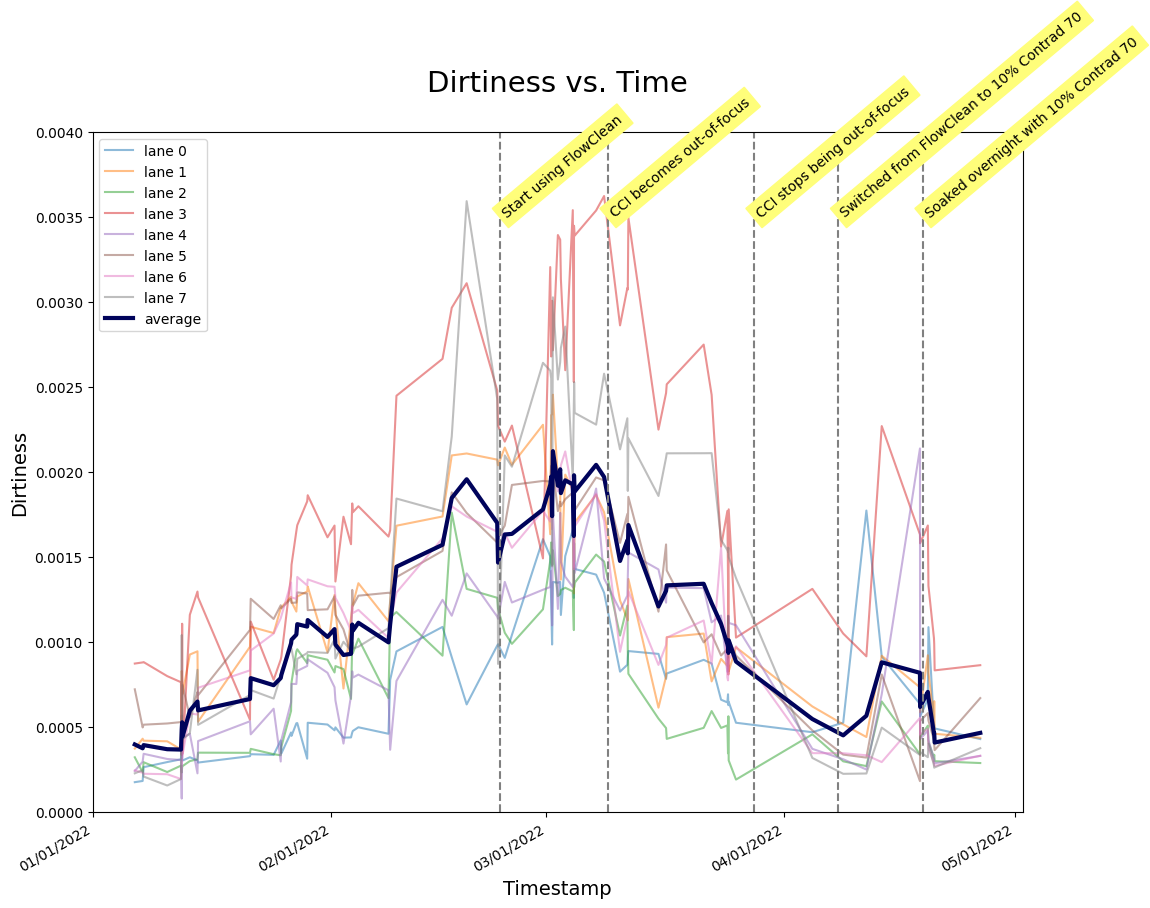

In [17]:
plt.figure(figsize=(12.,10.), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
for lane_no, rows in dirtinesses.items():
    if not rows:
        continue
    xs, ys = zip(*rows)
    ts = get_ts(xs)
    plt.plot(ts, ys, label=f"lane {lane_no}", alpha=0.5)
    
dirtiness_avgs = []
for run_no in range(len(dirtinesses[0])):
    dirtiness_sum = 0
    for lane_no in range(8):
        dirtiness_sum += dirtinesses[lane_no][run_no][1]
    dirtiness_avg = dirtiness_sum/8
    dirtiness_avgs.append(dirtiness_avg)
plt.plot(ts, dirtiness_avgs, label="average", lw=3, color='xkcd:dark blue')

for event_name in events:
    event_date = events[event_name]
    plt.axvline(x=event_date, color='gray', ls='--')
    plt.text(event_date, event_label_height, event_name, rotation=40, backgroundcolor='xkcd:light yellow')
    
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp', fontsize=fs)
plt.ylabel('Dirtiness', fontsize=fs)
plt.ylim(0, high_dirtiness_thresh)
plt.title('Dirtiness vs. Time\n', fontsize=fs*1.5)
plt.legend(loc='upper left')
plt.show()

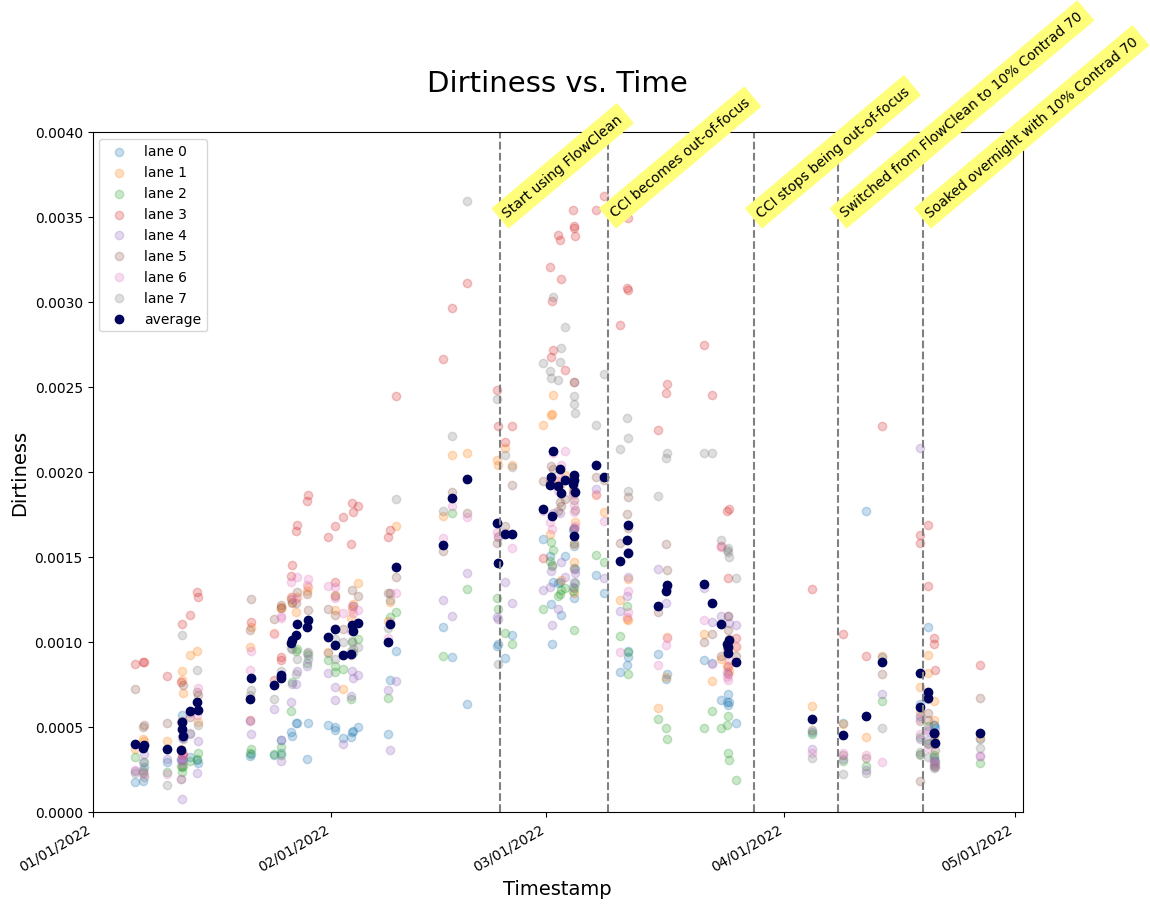

In [18]:
plt.figure(figsize=(12.,10.), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
for lane_no, rows in dirtinesses.items():
    if not rows:
        continue
    xs, ys = zip(*rows)
    ts = get_ts(xs)
    plt.scatter(ts, ys, label=f"lane {lane_no}", alpha=0.25)
    
dirtiness_avgs = []
for run_no in range(len(dirtinesses[0])):
    dirtiness_sum = 0
    for lane_no in range(8):
        dirtiness_sum += dirtinesses[lane_no][run_no][1]
    dirtiness_avg = dirtiness_sum/8
    dirtiness_avgs.append(dirtiness_avg)
plt.scatter(ts, dirtiness_avgs, label="average", facecolor='xkcd:dark blue')

for event_name in events:
    event_date = events[event_name]
    plt.axvline(x=event_date, color='gray', ls='--')
    plt.text(event_date, event_label_height, event_name, rotation=40, backgroundcolor='xkcd:light yellow')
    
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp', fontsize=fs)
plt.ylabel('Dirtiness', fontsize=fs)
plt.ylim(0, high_dirtiness_thresh)
plt.title('Dirtiness vs. Time\n', fontsize=fs*1.5)
plt.legend(loc='upper left')
plt.show()

# Images identified as having aberrations

In [19]:
fnames_high_dirtiness = []
vals_high_dirtiness = []
for lane_no, rows in dirtinesses.items():
    if not rows:
        continue
    for fname, dirtiness_val in rows:
        if dirtiness_val > high_dirtiness_thresh:
            fnames_high_dirtiness.append(fname)
            vals_high_dirtiness.append(dirtiness_val)
            print('%s\t%d' % (fname, dirtiness_val))

In [20]:
for fname, val in zip(fnames_high_dirtiness, vals_high_dirtiness):
    run_no = fname[11:26]
    path_cropped = base_dir + '/' + run_no + '/' + fname[:-4] + '_cropped.jpg'
    path_processed = base_dir + '/' + run_no + '/' + fname[:-4] + '_processed.jpg'
    im_cropped = imread(path_cropped)
    im_processed = imread(path_processed)
    
    fig, axs = plt.subplots(1,2, figsize=(10,14))
    axs[0].imshow(im_cropped)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title(fname)
    
    axs[1].imshow(im_processed)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title('dirtiness = %d'% val)

    plt.show()

# Example images not identified as having aberrations

In [21]:
normal_dirtiness_lo, normal_dirtiness_hi = 5000, 5200 # somewhat arbitrary 'very normal dirtiness' range
fnames_normal_dirtiness = []
vals_normal_dirtiness = []
for lane_no, rows in dirtinesses.items():
    if not rows:
            continue
    for fname, dirtiness_val in rows:
        if dirtiness_val > normal_dirtiness_lo and dirtiness_val < normal_dirtiness_hi:
            fnames_normal_dirtiness.append(fname)
            vals_normal_dirtiness.append(dirtiness_val)
            print('%s\t%d' % (fname, dirtiness_val))

In [22]:
for fname, val in zip(fnames_normal_dirtiness, vals_normal_dirtiness):
    run_no = fname[11:26]
    path_cropped = base_dir + '/' + run_no + '/' + fname[:-4] + '_cropped.jpg'
    path_processed = base_dir + '/' + run_no + '/' + fname[:-4] + '_processed.jpg'
    im_cropped = imread(path_cropped)
    im_processed = imread(path_processed)
    
    fig, axs = plt.subplots(1,2, figsize=(10,14))
    axs[0].imshow(im_cropped)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title(fname)
    
    axs[1].imshow(im_processed)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title('dirtiness = %d'% val)

    plt.show()